# 데이터 전처리
## 서울시 상권 추정 매출 데이터
- [데이터 출처](https://data.seoul.go.kr/dataList/OA-15572/S/1/datasetView.do)

## 0. 라이브러리 Import

In [1]:
# 라이브러리 import
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request
import requests
import json
import warnings

# 한글 폰트 설정
import matplotlib.font_manager as fm

# 시스템에 따른 한글 폰트 설정
font_list = [f.name for f in fm.fontManager.ttflist]

if 'AppleGothic' in font_list:
    plt.rcParams['font.family'] = 'AppleGothic'
elif 'Malgun Gothic' in font_list:
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif 'NanumGothic' in font_list:
    plt.rcParams['font.family'] = 'NanumGothic'
else:
    print("경고: 한글 폰트를 찾을 수 없습니다.")

plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

print(f"사용 중인 폰트: {plt.rcParams['font.family']}")

사용 중인 폰트: ['sans-serif']


## 1. CSV 데이터 로드 및 기본 정보 확인

In [2]:
# CSV 파일 읽기
df = pd.read_csv('data/seoul_2024.csv', encoding='euc-kr')

# 기본 정보
print(f"데이터 크기: {df.shape[0]:,}행 x {df.shape[1]}열")
print(f"메모리 사용량: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

df.head()

데이터 크기: 87,179행 x 55열
메모리 사용량: 61.20 MB


,기준_년분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,당월_매출_금액,당월_매출_건수,주중_매출_금액,...,시간대_건수~21_매출_건수,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수
0,20241,A,골목상권,3110001,이북5도청사,CS100001,한식음식점,385150643,11743,220129223,...,3496,52,6023,4281,26,508,935,1997,3135,3704
1,20241,A,골목상권,3110001,이북5도청사,CS100009,호프-간이주점,11026440,214,6576206,...,123,39,103,78,0,0,0,32,55,95
2,20241,A,골목상권,3110001,이북5도청사,CS200001,일반교습학원,52047765,224,50535211,...,112,8,48,176,0,0,8,152,64,0
3,20241,A,골목상권,3110002,독립문역 1번,CS100001,한식음식점,582522265,20630,404509479,...,5358,487,11887,7589,17,914,2595,3483,5408,7049
4,20241,A,골목상권,3110002,독립문역 1번,CS100005,제과점,446525280,40242,350264783,...,11472,2634,16005,22755,329,3589,7446,8867,9543,8986


## 2. 컬럼명 영문 변환 (분석 편의성)

In [3]:
# 컬럼명 매핑 (한글 -> 영문)
column_mapping = {
    '기준_년분기_코드': 'STDR_YYQU_CD',
    '상권_구분_코드': 'TRDAR_SE_CD',
    '상권_구분_코드_명': 'TRDAR_SE_CD_NM',
    '상권_코드': 'TRDAR_CD',
    '상권_코드_명': 'TRDAR_CD_NM',
    '서비스_업종_코드': 'SVC_INDUTY_CD',
    '서비스_업종_코드_명': 'SVC_INDUTY_CD_NM',
    '당월_매출_금액': 'THSMON_SELNG_AMT',
    '당월_매출_건수': 'THSMON_SELNG_CO',
    '주중_매출_금액': 'MDWK_SELNG_AMT',
    '주말_매출_금액': 'WKEND_SELNG_AMT',
    '월요일_매출_금액': 'MON_SELNG_AMT',
    '화요일_매출_금액': 'TUES_SELNG_AMT',
    '수요일_매출_금액': 'WED_SELNG_AMT',
    '목요일_매출_금액': 'THUR_SELNG_AMT',
    '금요일_매출_금액': 'FRI_SELNG_AMT',
    '토요일_매출_금액': 'SAT_SELNG_AMT',
    '일요일_매출_금액': 'SUN_SELNG_AMT',
    '시간대_00~06_매출_금액': 'TMZON_00_06_SELNG_AMT',
    '시간대_06~11_매출_금액': 'TMZON_06_11_SELNG_AMT',
    '시간대_11~14_매출_금액': 'TMZON_11_14_SELNG_AMT',
    '시간대_14~17_매출_금액': 'TMZON_14_17_SELNG_AMT',
    '시간대_17~21_매출_금액': 'TMZON_17_21_SELNG_AMT',
    '시간대_21~24_매출_금액': 'TMZON_21_24_SELNG_AMT',
    '남성_매출_금액': 'ML_SELNG_AMT',
    '여성_매출_금액': 'FML_SELNG_AMT',
    '연령대_10_매출_금액': 'AGRDE_10_SELNG_AMT',
    '연령대_20_매출_금액': 'AGRDE_20_SELNG_AMT',
    '연령대_30_매출_금액': 'AGRDE_30_SELNG_AMT',
    '연령대_40_매출_금액': 'AGRDE_40_SELNG_AMT',
    '연령대_50_매출_금액': 'AGRDE_50_SELNG_AMT',
    '연령대_60_이상_매출_금액': 'AGRDE_60_ABOVE_SELNG_AMT',
    '주중_매출_건수': 'MDWK_SELNG_CO',
    '주말_매출_건수': 'WKEND_SELNG_CO',
    '월요일_매출_건수': 'MON_SELNG_CO',
    '화요일_매출_건수': 'TUES_SELNG_CO',
    '수요일_매출_건수': 'WED_SELNG_CO',
    '목요일_매출_건수': 'THUR_SELNG_CO',
    '금요일_매출_건수': 'FRI_SELNG_CO',
    '토요일_매출_건수': 'SAT_SELNG_CO',
    '일요일_매출_건수': 'SUN_SELNG_CO',
    '시간대_건수~06_매출_건수': 'TMZON_00_06_SELNG_CO',
    '시간대_건수~11_매출_건수': 'TMZON_06_11_SELNG_CO',
    '시간대_건수~14_매출_건수': 'TMZON_11_14_SELNG_CO',
    '시간대_건수~17_매출_건수': 'TMZON_14_17_SELNG_CO',
    '시간대_건수~21_매출_건수': 'TMZON_17_21_SELNG_CO',
    '시간대_건수~24_매출_건수': 'TMZON_21_24_SELNG_CO',
    '남성_매출_건수': 'ML_SELNG_CO',
    '여성_매출_건수': 'FML_SELNG_CO',
    '연령대_10_매출_건수': 'AGRDE_10_SELNG_CO',
    '연령대_20_매출_건수': 'AGRDE_20_SELNG_CO',
    '연령대_30_매출_건수': 'AGRDE_30_SELNG_CO',
    '연령대_40_매출_건수': 'AGRDE_40_SELNG_CO',
    '연령대_50_매출_건수': 'AGRDE_50_SELNG_CO',
    '연령대_60_이상_매출_건수': 'AGRDE_60_ABOVE_SELNG_CO'
}

df = df.rename(columns=column_mapping)

## 3. 데이터 품질 체크

In [4]:
# 데이터 품질 확인
print("=== 데이터 타입 및 결측치 ===")
df.info()

print("\n=== 결측치 요약 ===")
missing = df.isnull().sum()
if missing.sum() > 0:
    missing_df = pd.DataFrame({
        '결측치 개수': missing[missing > 0],
        '결측치 비율(%)': (missing[missing > 0] / len(df) * 100).round(2)
    })
    print(missing_df)
else:
    print("결측치 없음")

print(f"\n중복 행: {df.duplicated().sum():,}개")

=== 데이터 타입 및 결측치 ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87179 entries, 0 to 87178
Data columns (total 55 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   STDR_YYQU_CD              87179 non-null  int64 
 1   TRDAR_SE_CD               87179 non-null  object
 2   TRDAR_SE_CD_NM            87179 non-null  object
 3   TRDAR_CD                  87179 non-null  int64 
 4   TRDAR_CD_NM               87179 non-null  object
 5   SVC_INDUTY_CD             87179 non-null  object
 6   SVC_INDUTY_CD_NM          87179 non-null  object
 7   THSMON_SELNG_AMT          87179 non-null  int64 
 8   THSMON_SELNG_CO           87179 non-null  int64 
 9   MDWK_SELNG_AMT            87179 non-null  int64 
 10  WKEND_SELNG_AMT           87179 non-null  int64 
 11  MON_SELNG_AMT             87179 non-null  int64 
 12  TUES_SELNG_AMT            87179 non-null  int64 
 13  WED_SELNG_AMT             87179 non-null  int64 
 14  T

In [5]:
# 기본 통계 정보
print("=== 상권 구분 ===")
print(df['TRDAR_SE_CD_NM'].value_counts())

print("\n=== 업종 분류 (상위 20개) ===")
print(df['SVC_INDUTY_CD_NM'].value_counts().head(20))

print(f"\n=== 기본 통계 ===")
print(f"기준 년분기: {sorted(df['STDR_YYQU_CD'].unique())}")
print(f"상권 개수: {df['TRDAR_CD'].nunique():,}개")
print(f"업종 개수: {df['SVC_INDUTY_CD_NM'].nunique()}개")

=== 상권 구분 ===
TRDAR_SE_CD_NM
골목상권    43950
발달상권    29303
전통시장    12933
관광특구      993
Name: count, dtype: int64

=== 업종 분류 (상위 20개) ===
SVC_INDUTY_CD_NM
한식음식점      5645
미용실        4468
커피-음료      4348
호프-간이주점    3641
슈퍼마켓       3549
일반의류       3495
분식전문점      3224
편의점        2859
일반교습학원     2591
의약품        2345
치킨전문점      2196
노래방        2091
예술학원       2078
일반의원       2068
화장품        2040
스포츠 강습     1954
중식음식점      1839
제과점        1719
패스트푸드점     1718
세탁소        1701
Name: count, dtype: int64

=== 기본 통계 ===
기준 년분기: [np.int64(20241), np.int64(20242), np.int64(20243), np.int64(20244)]
상권 개수: 1,581개
업종 개수: 62개


## 4. 데이터 클리닝

In [6]:
# 데이터 클리닝
df_raw = df.copy()  # 백업

# 중복 제거
initial_rows = len(df)
df = df.drop_duplicates()
print(f"중복 행 제거: {initial_rows - len(df):,}개")

# 결측치 처리
missing_counts = df.isnull().sum().sum()
if missing_counts > 0:
    df = df.fillna(0)
    print(f"결측치 처리: {missing_counts:,}개")

# 데이터 타입 최적화
df['STDR_YYQU_CD'] = df['STDR_YYQU_CD'].astype(str)

print(f"\n최종 데이터: {df.shape[0]:,}행 x {df.shape[1]}열")
print(f"메모리: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

중복 행 제거: 0개

최종 데이터: 87,179행 x 55열
메모리: 68.96 MB


## 5. 데이터 분포 및 이상치 확인

In [7]:
# 주요 수치형 변수 기술통계
numeric_cols = ['THSMON_SELNG_AMT', 'THSMON_SELNG_CO', 
                'MDWK_SELNG_AMT', 'WKEND_SELNG_AMT',
                'ML_SELNG_AMT', 'FML_SELNG_AMT']

print("=== 주요 변수 기술통계 ===")
print(df[numeric_cols].describe())

# 이상치 확인 (IQR 방식)
print("\n=== 이상치 확인 (IQR 기준) ===")
for col in ['THSMON_SELNG_AMT', 'THSMON_SELNG_CO']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"{col}: {len(outliers):,}개 ({len(outliers)/len(df)*100:.2f}%)")

=== 주요 변수 기술통계 ===
       THSMON_SELNG_AMT  THSMON_SELNG_CO  MDWK_SELNG_AMT  WKEND_SELNG_AMT  \
count      8.717900e+04     8.717900e+04    8.717900e+04     8.717900e+04   
mean       1.064983e+09     3.608262e+04    8.074585e+08     2.575241e+08   
std        9.668534e+09     1.730819e+05    6.471138e+09     3.508493e+09   
min        1.900000e+02     1.000000e+00    0.000000e+00     0.000000e+00   
25%        4.705591e+07     8.150000e+02    3.485938e+07     7.079930e+06   
50%        1.750161e+08     4.286000e+03    1.310675e+08     3.570934e+07   
75%        6.252001e+08     2.227650e+04    4.729417e+08     1.364505e+08   
max        1.144904e+12     1.284697e+07    6.824397e+11     4.712509e+11   

       ML_SELNG_AMT  FML_SELNG_AMT  
count  8.717900e+04   8.717900e+04  
mean   4.862587e+08   4.593941e+08  
std    4.726164e+09   3.745730e+09  
min    0.000000e+00   0.000000e+00  
25%    1.875362e+07   1.723548e+07  
50%    7.814533e+07   7.023638e+07  
75%    2.896601e+08   2.6073

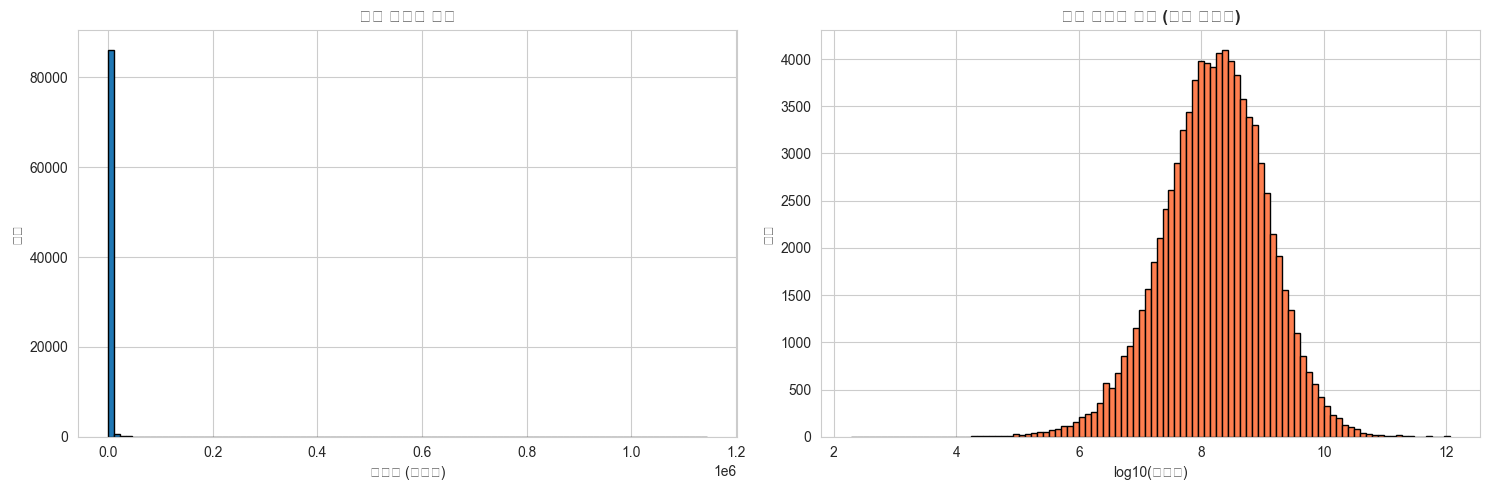


중앙값: 175.02백만원
평균값: 1064.98백만원
왜도(Skewness): 70.49


In [8]:
# 매출액 분포 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 히스토그램
axes[0].hist(df['THSMON_SELNG_AMT'] / 1e6, bins=100, edgecolor='black')
axes[0].set_title('당월 매출액 분포', fontsize=12, fontweight='bold')
axes[0].set_xlabel('매출액 (백만원)')
axes[0].set_ylabel('빈도')

# 로그 스케일 히스토그램
axes[1].hist(np.log10(df['THSMON_SELNG_AMT'] + 1), bins=100, edgecolor='black', color='coral')
axes[1].set_title('당월 매출액 분포 (로그 스케일)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('log10(매출액)')
axes[1].set_ylabel('빈도')

plt.tight_layout()
plt.show()

print(f"\n중앙값: {df['THSMON_SELNG_AMT'].median()/1e6:.2f}백만원")
print(f"평균값: {df['THSMON_SELNG_AMT'].mean()/1e6:.2f}백만원")
print(f"왜도(Skewness): {df['THSMON_SELNG_AMT'].skew():.2f}")

## 6. 원본 데이터 상관관계 분석

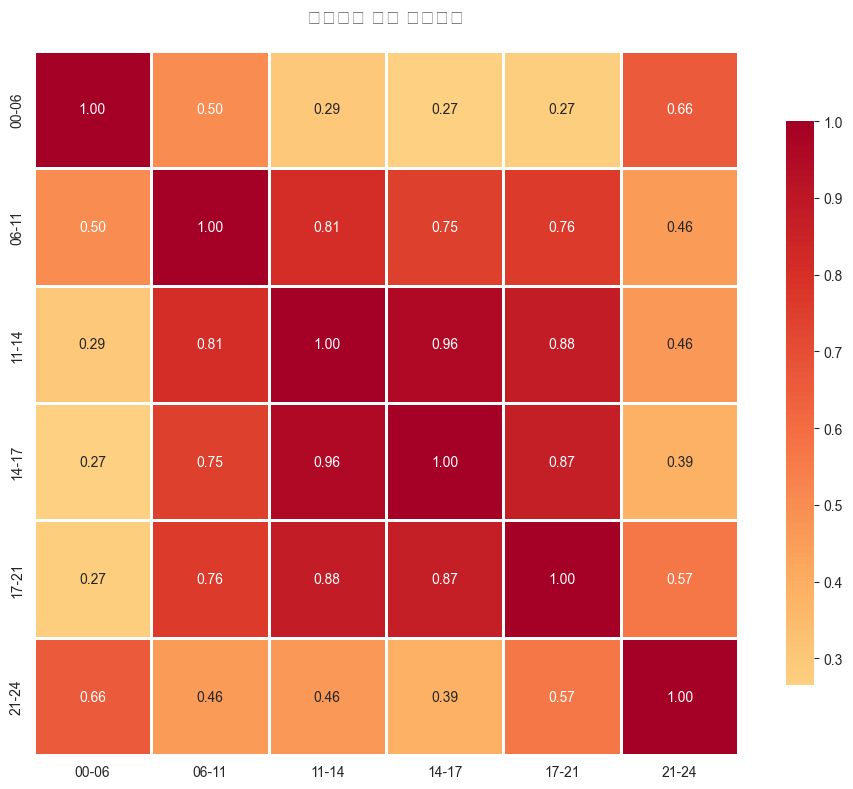

시간대별 상관관계 인사이트:
- 17-21시와 21-24시 매출 상관도가 높음 -> 야간 경제 지표로 통합 가능
- 11-14시와 14-17시 상관도 높음 -> 낮 시간대 특성 유사


In [9]:
# 시간대별 매출 상관관계
time_cols = ['TMZON_00_06_SELNG_AMT', 'TMZON_06_11_SELNG_AMT', 'TMZON_11_14_SELNG_AMT',
             'TMZON_14_17_SELNG_AMT', 'TMZON_17_21_SELNG_AMT', 'TMZON_21_24_SELNG_AMT']

time_corr = df[time_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(time_corr, annot=True, fmt='.2f', cmap='RdYlBu_r', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            xticklabels=['00-06', '06-11', '11-14', '14-17', '17-21', '21-24'],
            yticklabels=['00-06', '06-11', '11-14', '14-17', '17-21', '21-24'])
plt.title('시간대별 매출 상관관계', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("시간대별 상관관계 인사이트:")
print("- 17-21시와 21-24시 매출 상관도가 높음 -> 야간 경제 지표로 통합 가능")
print("- 11-14시와 14-17시 상관도 높음 -> 낮 시간대 특성 유사")

In [10]:
# 상관관계 분석 결과를 바탕으로 파생변수 설계
print("=== 파생변수 설계 근거 ===")
print("\n[시간대 분석 결과]")
print("- 17-21시와 21-24시 높은 상관관계 -> '야간매출비율' 통합 지표 생성")
print("- 00-06시 독립적 패턴 -> '심야영업비율' 별도 지표")

print("\n[요일 분석 결과]")
print("- 평일 간 높은 상관관계, 주말과 구분 -> '주말매출비율' 지표")
print("- 요일별 변동성 -> '요일별변동계수' 안정성 지표")

print("\n[연령대 분석 결과]")
print("- 20-40대 높은 상관관계 -> '주력소비층비율' 통합")
print("- 20-30대 청년층 특성 -> '청년층비율' 지표")
print("- 50-60대 시니어층 특성 -> '시니어층비율' 지표")

=== 파생변수 설계 근거 ===

[시간대 분석 결과]
- 17-21시와 21-24시 높은 상관관계 -> '야간매출비율' 통합 지표 생성
- 00-06시 독립적 패턴 -> '심야영업비율' 별도 지표

[요일 분석 결과]
- 평일 간 높은 상관관계, 주말과 구분 -> '주말매출비율' 지표
- 요일별 변동성 -> '요일별변동계수' 안정성 지표

[연령대 분석 결과]
- 20-40대 높은 상관관계 -> '주력소비층비율' 통합
- 20-30대 청년층 특성 -> '청년층비율' 지표
- 50-60대 시니어층 특성 -> '시니어층비율' 지표


## 8. 전처리된 데이터 저장

In [11]:
# 데이터 저장
output_csv = 'data/processed_data/seoul_2024_preprocessed.csv'
output_pkl = 'data/processed_data/seoul_2024_preprocessed.pkl'

df.to_csv(output_csv, index=False, encoding='euc-kr')
df.to_pickle(output_pkl)

print(f"저장 완료:")
print(f"  CSV: {output_csv}")
print(f"  Pickle: {output_pkl}")
print(f"  행: {len(df):,}, 열: {len(df.columns)}")

저장 완료:
  CSV: data/processed_data/seoul_2024_preprocessed.csv
  Pickle: data/processed_data/seoul_2024_preprocessed.pkl
  행: 87,179, 열: 55


## 7. 상관관계 기반 파생변수 설계 및 생성

In [12]:
# 파생변수 생성 (상관관계 분석 기반)

# 1. 시간적 활력 지표 (시간대 상관관계 기반)
df['야간매출비율'] = ((df['TMZON_17_21_SELNG_AMT'] + df['TMZON_21_24_SELNG_AMT']) / 
                     df['THSMON_SELNG_AMT'] * 100).round(2)
df['야간거래비율'] = ((df['TMZON_17_21_SELNG_CO'] + df['TMZON_21_24_SELNG_CO']) / 
                     df['THSMON_SELNG_CO'] * 100).round(2)
df['심야영업비율'] = (df['TMZON_00_06_SELNG_AMT'] / df['THSMON_SELNG_AMT'] * 100).round(2)

# 2. 요일별 활력 지표 (요일 상관관계 기반)
df['주말매출비율'] = (df['WKEND_SELNG_AMT'] / df['THSMON_SELNG_AMT'] * 100).round(2)
df['주말거래비율'] = (df['WKEND_SELNG_CO'] / df['THSMON_SELNG_CO'] * 100).round(2)

day_cols = ['MON_SELNG_AMT', 'TUES_SELNG_AMT', 'WED_SELNG_AMT', 
            'THUR_SELNG_AMT', 'FRI_SELNG_AMT', 'SAT_SELNG_AMT', 'SUN_SELNG_AMT']
df['요일별변동계수'] = (df[day_cols].std(axis=1) / df[day_cols].mean(axis=1) * 100).round(2)
df['요일별변동계수'] = df['요일별변동계수'].replace([np.inf, -np.inf], 0)

# 3. 인구학적 지표 (연령대 상관관계 기반)
df['주력소비층비율'] = ((df['AGRDE_20_SELNG_AMT'] + df['AGRDE_30_SELNG_AMT'] + 
                       df['AGRDE_40_SELNG_AMT']) / df['THSMON_SELNG_AMT'] * 100).round(2)
df['청년층비율'] = ((df['AGRDE_20_SELNG_AMT'] + df['AGRDE_30_SELNG_AMT']) / 
                   df['THSMON_SELNG_AMT'] * 100).round(2)
df['시니어층비율'] = ((df['AGRDE_50_SELNG_AMT'] + df['AGRDE_60_ABOVE_SELNG_AMT']) / 
                     df['THSMON_SELNG_AMT'] * 100).round(2)

# 4. 소비력 지표
df['평균거래단가'] = (df['THSMON_SELNG_AMT'] / df['THSMON_SELNG_CO']).round(0)
df['여성소비비율'] = (df['FML_SELNG_AMT'] / df['THSMON_SELNG_AMT'] * 100).round(2)

# 5. 년도/분기 분리
df['년도'] = df['STDR_YYQU_CD'].str[:4]
df['분기'] = df['STDR_YYQU_CD'].str[4]

print(f"파생변수 생성 완료 (총 {len(df.columns)}개 컬럼)")

파생변수 생성 완료 (총 68개 컬럼)


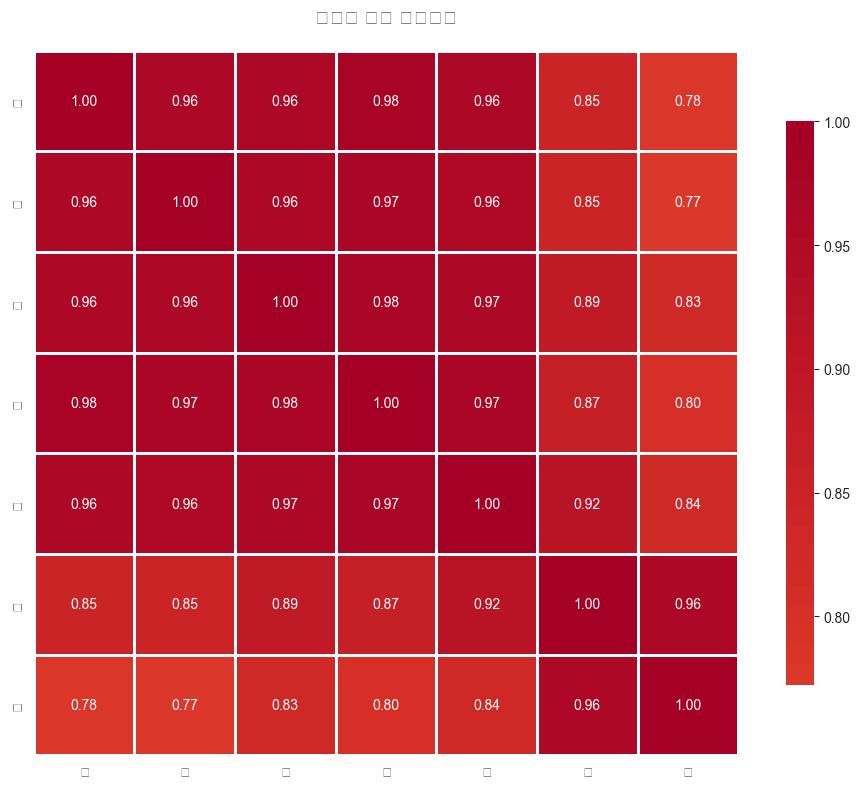

요일별 상관관계 인사이트:
- 평일(월-금) 간 상관도 매우 높음 -> 주중 패턴 일관적
- 토-일 상관도 높음 -> 주말 패턴 유사
- 주중-주말 간 상관도 낮음 -> 주말매출비율 지표 의미있음


In [13]:
# 요일별 매출 상관관계
day_cols = ['MON_SELNG_AMT', 'TUES_SELNG_AMT', 'WED_SELNG_AMT', 
            'THUR_SELNG_AMT', 'FRI_SELNG_AMT', 'SAT_SELNG_AMT', 'SUN_SELNG_AMT']

day_corr = df[day_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(day_corr, annot=True, fmt='.2f', cmap='RdYlBu_r', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            xticklabels=['월', '화', '수', '목', '금', '토', '일'],
            yticklabels=['월', '화', '수', '목', '금', '토', '일'])
plt.title('요일별 매출 상관관계', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("요일별 상관관계 인사이트:")
print("- 평일(월-금) 간 상관도 매우 높음 -> 주중 패턴 일관적")
print("- 토-일 상관도 높음 -> 주말 패턴 유사")
print("- 주중-주말 간 상관도 낮음 -> 주말매출비율 지표 의미있음")

In [14]:
# 파생변수 미리보기
cols_to_show = ['TRDAR_CD_NM', 'SVC_INDUTY_CD_NM', 'THSMON_SELNG_AMT', 
                '야간매출비율', '주말매출비율', '청년층비율', '평균거래단가']
df[cols_to_show].head(10)

,TRDAR_CD_NM,SVC_INDUTY_CD_NM,THSMON_SELNG_AMT,야간매출비율,주말매출비율,청년층비율,평균거래단가
0,이북5도청사,한식음식점,385150643,38.79,42.85,8.81,32798.0
1,이북5도청사,호프-간이주점,11026440,76.37,40.36,0.00,51525.0
2,이북5도청사,일반교습학원,52047765,53.70,2.91,2.91,232356.0
3,독립문역 1번,한식음식점,582522265,36.65,30.56,14.93,28237.0
4,독립문역 1번,제과점,446525280,28.76,21.56,18.40,11096.0
5,독립문역 1번,치킨전문점,55508235,93.56,32.56,26.04,30021.0
6,독립문역 1번,커피-음료,56568383,22.83,23.91,26.31,8692.0
7,독립문역 1번,일반교습학원,37534297,70.66,0.00,0.00,421734.0
8,독립문역 1번,미용실,24764115,48.88,29.46,23.95,30801.0
9,독립문역 1번,의약품,3791674246,8.14,2.96,5.31,32089.0


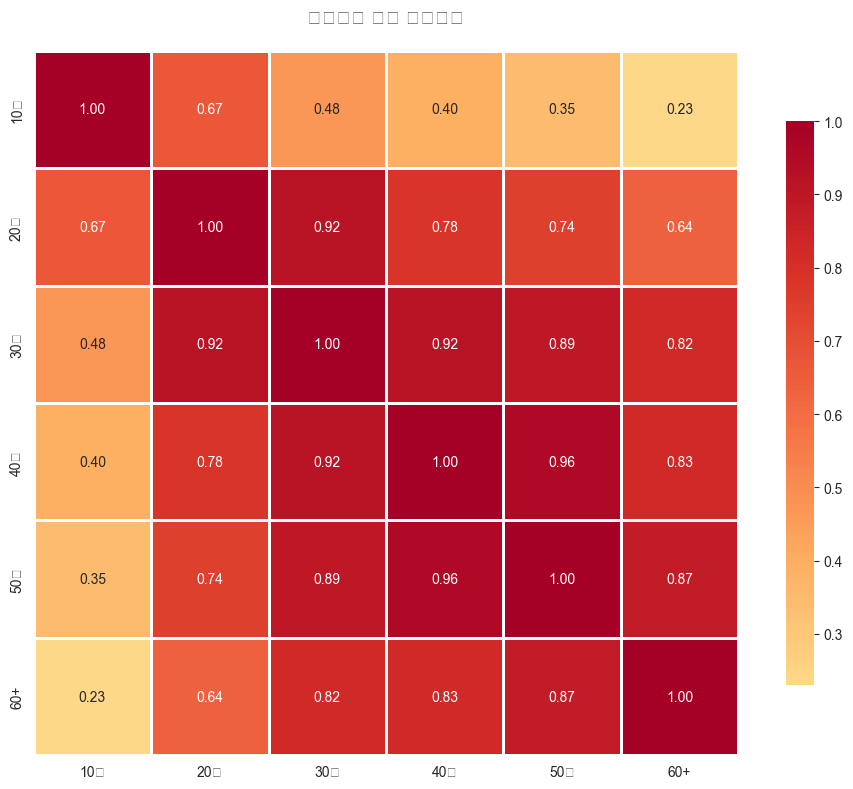

연령대별 상관관계 인사이트:
- 20-30대, 30-40대 간 상관도 높음 -> 주력 소비층 특성 유사
- 50-60대 간 상관도 높음 -> 시니어층 소비 패턴 유사
- 10대는 다른 연령대와 상관도 낮음 -> 독립적 소비 패턴


In [15]:
# 연령대별 매출 상관관계
age_cols = ['AGRDE_10_SELNG_AMT', 'AGRDE_20_SELNG_AMT', 'AGRDE_30_SELNG_AMT',
            'AGRDE_40_SELNG_AMT', 'AGRDE_50_SELNG_AMT', 'AGRDE_60_ABOVE_SELNG_AMT']

age_corr = df[age_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(age_corr, annot=True, fmt='.2f', cmap='RdYlBu_r', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            xticklabels=['10대', '20대', '30대', '40대', '50대', '60+'],
            yticklabels=['10대', '20대', '30대', '40대', '50대', '60+'])
plt.title('연령대별 매출 상관관계', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("연령대별 상관관계 인사이트:")
print("- 20-30대, 30-40대 간 상관도 높음 -> 주력 소비층 특성 유사")
print("- 50-60대 간 상관도 높음 -> 시니어층 소비 패턴 유사")
print("- 10대는 다른 연령대와 상관도 낮음 -> 독립적 소비 패턴")